In [1]:
# import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
import keras
from keras.layers import Dense,Input, InputLayer, Flatten
from keras.models import Sequential, Model, load_model
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix,f1_score


2024-05-07 19:23:09.589283: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-07 19:23:09.589407: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-07 19:23:09.724717: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:

def load_and_preprocess_data(data_dir, image_size):
    images = []
    labels = []

    # Augmentation parameters
    augmentation_params = {
        'rotation_range': 15,
        'saturation_range': 0.15,
        'brightness_range': 0.1,
        'horizontal_flip': True,
        'vertical_flip': True,
    }

    # Iterate through each folder (each class of images)
    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)

        # Iterate through each image in the class folder
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)

            # Read image
            image = cv2.imread(image_path)  # reads in BGR format
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Number of augmented images per original image
            num_augmented_images_per_original = 4

            # Apply augmentation
            augmented_images = [image]  # Start with the original image
            for _ in range(num_augmented_images_per_original):
                augmented_image = image.copy()
                augmented_image = apply_augmentation(augmented_image, augmentation_params)
                augmented_images.append(augmented_image)

            # Resize augmented images
            augmented_images = [cv2.resize(img, image_size) for img in augmented_images]

            # Normalize pixel values to [0, 1]
            augmented_images = [img.astype('float32') / 255.0 for img in augmented_images]

            # Append to the lists
            images.extend(augmented_images)
            labels.extend([class_name] * len(augmented_images))

    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    return images, labels


def apply_augmentation(image, params):
    # Randomly apply rotation
    if params['rotation_range'] != 0:
        angle = np.random.uniform(-params['rotation_range'], params['rotation_range'])
        rows, cols = image.shape[:2]
        rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
        image = cv2.warpAffine(image, rotation_matrix, (cols, rows))

    # Randomly apply shear
  

    # Randomly adjust saturation
    if params['saturation_range'] != 0:
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        saturation_factor = 1 + np.random.uniform(-params['saturation_range'], params['saturation_range'])
        hsv[:, :, 1] = np.clip(hsv[:, :, 1] * saturation_factor, 0, 255)
        image = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    # Randomly adjust brightness
    if params['brightness_range'] != 0:
        brightness_factor = 1 + np.random.uniform(-params['brightness_range'], params['brightness_range'])
        image = np.clip(image * brightness_factor, 0, 255).astype(np.uint8)

    # Randomly flip horizontally
    if params['horizontal_flip']:
        if np.random.random() < 0.5:
            image = cv2.flip(image, 1)

    # Randomly flip vertically
    if params['vertical_flip']:
        if np.random.random() < 0.5:
            image = cv2.flip(image, 0)

    return image


In [3]:
dataset_dir = r"/kaggle/input/gemstones-images-expanded/dataset-expanded"

In [4]:
image_size = (128, 128)

images, labels = load_and_preprocess_data(dataset_dir, image_size)

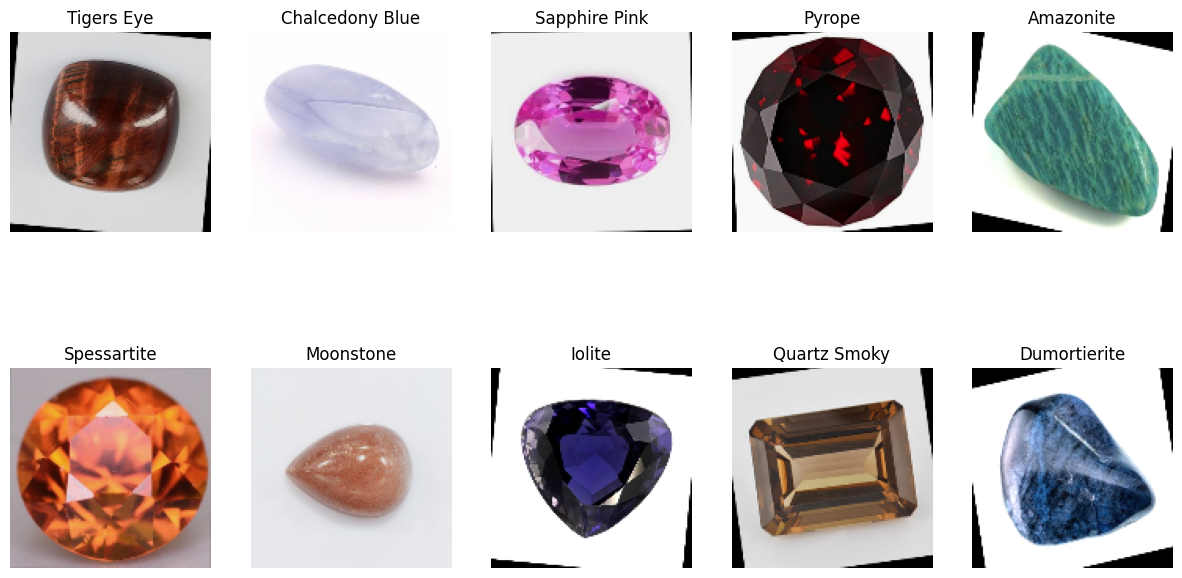

In [5]:
import matplotlib.pyplot as plt
import random

# Select 10 random indices
random_indices = random.sample(range(len(images)), 10)

# Plot the images
plt.figure(figsize=(15, 8))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[idx])
    plt.title(labels[idx])
    plt.axis('off')
plt.show()

In [6]:
from sklearn.preprocessing import OneHotEncoder

# Reshape labels array to fit OneHotEncoder input
labels = labels.reshape(-1, 1)

# Initialize OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)

# Fit and transform the labels
onehot_labels = onehot_encoder.fit_transform(labels)

# Check the shape of onehot_labels
print("Shape of onehot_labels:", onehot_labels.shape)

# Print the first few one-hot encoded labels
print("First few one-hot encoded labels:")
print(onehot_labels[:5])

Shape of onehot_labels: (22000, 88)
First few one-hot encoded labels:
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [7]:
from sklearn.model_selection import train_test_split


# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, onehot_labels, test_size=0.33, random_state=42)

y_train = np.array(y_train)
y_test = np.array(y_test)
X_train = np.array(X_train)
X_test = np.array(X_test)

# Check the shapes of the datasets
print("Train images shape:", X_train.shape)
print("Train labels shape:", X_test.shape)
print("Validation images shape:", y_train.shape)
print("Validation labels shape:", y_test.shape)

Train images shape: (14740, 128, 128, 3)
Train labels shape: (7260, 128, 128, 3)
Validation images shape: (14740, 88)
Validation labels shape: (7260, 88)


In [8]:
from sklearn.utils import shuffle

# Shuffle the training set
X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train, random_state=42)

# Shuffle the test set (optional, depending on your requirements)
X_test_shuffled, y_test_shuffled = shuffle(X_test, y_test, random_state=42)

# Check the shapes of the shuffled datasets
print("Shuffled train images shape:", X_train_shuffled.shape)
print("Shuffled train labels shape:", y_train_shuffled.shape)
print("Shuffled test images shape:", X_test_shuffled.shape)
print("Shuffled test labels shape:", y_test_shuffled.shape)

Shuffled train images shape: (14740, 128, 128, 3)
Shuffled train labels shape: (14740, 88)
Shuffled test images shape: (7260, 128, 128, 3)
Shuffled test labels shape: (7260, 88)


In [14]:
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)),
    keras.layers.Conv2D(64, (3, 3), activation='relu', strides=(2, 2), padding='same'),
    keras.layers.Dropout(0.25),
    keras.layers.Conv2D(86, (3, 3), activation='relu', padding='same'),
     keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (3, 3), strides=(2, 2), activation='relu', padding='same'),
    keras.layers.Dropout(0.125),

    keras.layers.Conv2D(256, (3, 3), strides=(2, 2), activation='relu', padding='same'),
    keras.layers.Dropout(0.25),
    keras.layers.BatchNormalization(),
    keras.layers.GlobalAveragePooling2D(),  
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(32, activation='relu'),
        
    keras.layers.Dense(88, activation='softmax')
])
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 86)     │        49,622 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 86)     │           344 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 128)    │        99,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 88)             │         2,904 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 541,670 (2.07 MB)

 Trainable params: 540,986 (2.06 MB)

 Non-trainable params: 684 (2.67 KB)

In [15]:
from keras.optimizers import Adam

# Compile the model
initial_lr = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_lr, decay_steps=10000, decay_rate=0.9
)
optimizer = Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train_shuffled, y_train_shuffled, epochs=60, validation_split=0.2)

Epoch 1/60
369/369 ━━━━━━━━━━━━━━━━━━━━ 32s 58ms/step - accuracy: 0.0330 - loss: 4.3550 - val_accuracy: 0.0570 - val_loss: 4.1275
Epoch 2/60
369/369 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.1100 - loss: 3.7440 - val_accuracy: 0.1649 - val_loss: 3.2489
Epoch 3/60
369/369 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.1764 - loss: 3.1904 - val_accuracy: 0.2307 - val_loss: 2.7660
Epoch 4/60
369/369 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.2463 - loss: 2.7426 - val_accuracy: 0.3253 - val_loss: 2.3968
Epoch 5/60
369/369 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.2958 - loss: 2.4636 - val_accuracy: 0.3331 - val_loss: 2.3082
Epoch 6/60
369/369 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.3424 - loss: 2.2583 - val_accuracy: 0.4115 - val_loss: 1.9956
Epoch 7/60
369/369 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.3766 - loss: 2.1150 - val_accuracy: 0.4362 - val_loss: 1.8370
Epoch 8/60
369/369 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.4069 - loss: 1.9891 - 

In [17]:
from sklearn.metrics import f1_score, classification_report

# Convert one-hot encoded y_test_shuffled to class labels
y_test_labels = np.argmax(y_test_shuffled, axis=1)

# Make predictions and convert them to class labels
predicted_labels = model.predict(X_test_shuffled)
predicted_labels = np.argmax(predicted_labels, axis=1)

# Calculate F1 score and classification report
f1 = f1_score(y_test_labels, predicted_labels, average='macro')
report = classification_report(y_test_labels, predicted_labels)

print("F1 Score:", f1)
print("Classification Report:")
print(report)


227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
F1 Score: 0.7402493217127716
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.81      0.75        79
           1       0.67      0.41      0.51        81
           2       0.78      0.92      0.84        76
           3       0.83      0.47      0.60        81
           4       0.66      0.55      0.60        76
           5       0.87      0.93      0.90        86
           6       0.67      0.62      0.65        88
           7       0.47      0.45      0.46        84
           8       0.72      0.83      0.77        86
           9       0.87      0.86      0.87        86
          10       0.93      0.66      0.77        82
          11       0.59      0.82      0.69        85
          12       0.54      0.44      0.48        87
          13       0.81      0.76      0.78        76
          14       0.87      0.85      0.86        88
          15       1.00      0.91      0.9

In [ ]:
# Check label consistency
print("Training labels:", np.unique(np.argmax(y_train, axis=1)))
print("Testing labels:", np.unique(np.argmax(y_test, axis=1)))

# Check data augmentation
print("Train images shape:", X_train.shape)
print("Test images shape:", X_test.shape)

# Check data augmentation
print("Train images shape:", X_train.shape)
print("Test images shape:", X_test.shape)

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# Convert one-hot encoded labels back to class indices
train_labels_indices = np.argmax(y_train, axis=1)
test_labels_indices = np.argmax(y_test, axis=1)

# Calculate class distribution in training and testing data
train_class_distribution = np.bincount(train_labels_indices)
test_class_distribution = np.bincount(test_labels_indices)

# Plot class distribution
plt.figure(figsize=(12, 6))
plt.bar(np.arange(len(train_class_distribution)), train_class_distribution, color='blue', label='Train Data')
plt.bar(np.arange(len(test_class_distribution)), test_class_distribution, color='red', label='Test Data')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.legend()
plt.show()


In [ ]:
model.save("ai_model_87.h5")